In [ ]:
!git clone https://github.com/ezaaputra/indonlu.git

!pip install emoji
!pip install transformers
!pip install datasets
!pip install torch

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

#NLP
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import emoji

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

#Model IndOBERT
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

#Library IndoBERT
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup


Cloning into 'indonlu'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 460 (delta 119), reused 108 (delta 108), pack-reused 312 (from 1)
Receiving objects: 100% (460/460), 4.83 MiB | 9.34 MiB/s, done.
Resolving deltas: 100% (229/229), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR:

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else :
    print('No GPU available, using the CPU')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
df = pd.read_csv('processed_paslon2_2label.csv', sep=';')
df

,normalized_text,sentimen
0,padahal sudah ngerahin bot buat menyerang andi...,negatif
1,kasus ini jaman sih lutfi tukang remes pantat ...,negatif
2,calon gubernur jawa tengah ahmad luthfi,positif
3,sudah waktunya jateng dipimpin pemimpin yang t...,positif
4,bismillah semua karena allah ayo dukung pak ah...,positif
...,...,...
1441,calon gubernur jateng nomor ini sepertinya tid...,negatif
1442,masih banyaknya pemilih bimbang juga karena ti...,negatif
1443,di sisa waktu ini kurang lebih hari semua tim ...,positif
1444,bantu analis buat rakyat jtg polri mantan jtg ...,positif


Jumlah Sentimen:
 sentimen
positif    929
negatif    517
Name: count, dtype: int64


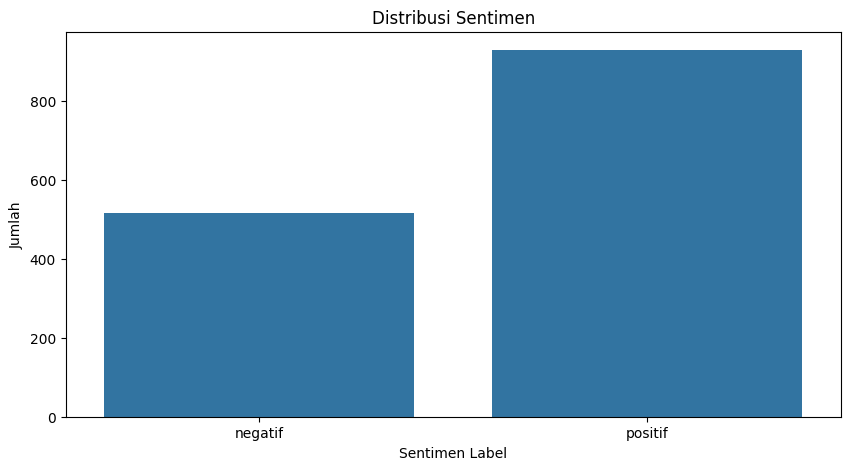

In [ ]:
# Menghitung jumlah setiap sentimen_label
sentimen_counts = df['sentimen'].value_counts()

# Menampilkan jumlah sentimen dalam bentuk tabel
print("Jumlah Sentimen:\n", sentimen_counts)

# Menampilkan sentimen dalam bentuk grafik
plt.figure(figsize=(10, 5))
sns.countplot(x='sentimen', data=df)
plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen Label')
plt.ylabel('Jumlah')
plt.show()

In [ ]:
# Melihat distribusi label
label_counts = df['sentimen'].value_counts()
print("\nDistribusi Label:")
print(f"positif (1): {label_counts.get(1, 0)}")
print(f"negatif (0): {label_counts.get(0, 0)}")


Distribusi Label:
positif (1): 517
negatif (0): 929


<ipython-input-132-2ad2dc9452d0>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"positif (1): {label_counts.get(1, 0)}")
<ipython-input-132-2ad2dc9452d0>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"negatif (0): {label_counts.get(0, 0)}")


In [ ]:
# Memeriksa keseimbangan kelas
total_samples = len(df)
class_balance = {
    'Positif': f"{(label_counts.get(1, 0) / total_samples) * 100:.2f}%",
    'Negatif': f"{(label_counts.get(0, 0) / total_samples) * 100:.2f}%"
}
print("\nKeseimbangan Kelas:")
for label, percentage in class_balance.items():
    print(f"{label}: {percentage}")


Keseimbangan Kelas:
Positif: 35.75%
Negatif: 64.25%


<ipython-input-133-c80dff8763a1>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Positif': f"{(label_counts.get(1, 0) / total_samples) * 100:.2f}%",
<ipython-input-133-c80dff8763a1>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Negatif': f"{(label_counts.get(0, 0) / total_samples) * 100:.2f}%"


In [ ]:
# Membagi dataset menjadi train, validation, dan test
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['sentimen'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['sentimen'], random_state=42)

print(f"\nTrain set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Train set size: 1012
Validation set size: 217
Test set size: 217


In [ ]:
# Menyimpan data menjadi file TSV
train_df.to_csv('train.tsv', sep='\t', index=False)
val_df.to_csv('val.tsv', sep='\t', index=False)
test_df.to_csv('test.tsv', sep='\t', index=False)

print("File TSV berhasil dibuat.")

File TSV berhasil dibuat.


In [ ]:
# Import library yang diperlukan
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
import torch

# Load IndoBERT tokenizer dan config
model_name = "indolem/indobertweet-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name, num_labels=2)  # 2 kelas: positif dan negatif

# Menghitung parameter model
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {total_params - trainable_params:,}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Total parameters: 110,559,746
Trainable parameters: 110,559,746
Non-trainable parameters: 0


In [ ]:
from torch.utils.data import Dataset

# Membuat custom dataset dengan nama kolom yang benar
class SentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128, text_column='normalized_text', label_column='sentimen'):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text_column = text_column
        self.label_column = label_column

        # Pastikan kolom yang diperlukan ada
        if self.text_column not in self.data.columns:
            raise ValueError(f"Kolom '{self.text_column}' tidak ditemukan. Kolom yang tersedia: {self.data.columns.tolist()}")
        if self.label_column not in self.data.columns:
            raise ValueError(f"Kolom '{self.label_column}' tidak ditemukan. Kolom yang tersedia: {self.data.columns.tolist()}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index][self.text_column]
        label = self.data.iloc[index][self.label_column]

        # Ensure text is a string
        if not isinstance(text, str):
            text = str(text)

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Membaca file TSV dan membuat dataset
import pandas as pd

def read_tsv(file_path):
    df = pd.read_csv(file_path, sep='\t')
    # Mengubah label sentimen menjadi numerik
    df['sentimen'] = df['sentimen'].map({'negatif': 0, 'positif': 1})
    return df

# Membaca file TSV dan membuat dataset
train_data = read_tsv('train.tsv')
val_data = read_tsv('val.tsv')
test_data = read_tsv('test.tsv')

# Membuat dataset menggunakan custom class dengan nama kolom yang benar
train_dataset = SentimentDataset(train_data, tokenizer, text_column='normalized_text', label_column='sentimen')
val_dataset = SentimentDataset(val_data, tokenizer, text_column='normalized_text', label_column='sentimen')
test_dataset = SentimentDataset(test_data, tokenizer, text_column='normalized_text', label_column='sentimen')

In [ ]:
from torch.utils.data import DataLoader

# Membuat DataLoader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Menyiapkan model untuk fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)
model = model.to(device)

# Menentukan optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, eps=1e-8)

# Mendapatkan nilai learning rate
num_epochs = 3
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        predictions = torch.argmax(outputs.logits, dim=-1)
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy

In [ ]:
# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            total_loss += outputs.loss.item()

            predictions = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=['negatif', 'positif'], digits=4)

    return avg_loss, accuracy, report


In [ ]:
# Training function
from sklearn.metrics import accuracy_score

# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print(f"\nMulai training untuk {num_epochs} epochs...")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training
    train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    val_loss, val_acc, val_report = evaluate(model, val_dataloader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
    print("Validation Classification Report:")
    print(val_report)


Mulai training untuk 3 epochs...

Epoch 1/3


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]


Train Loss: 0.5299, Train Accuracy: 0.7233
Val Loss: 0.4166, Val Accuracy: 0.8341
Validation Classification Report:
              precision    recall  f1-score   support

     negatif     0.8060    0.7013    0.7500        77
     positif     0.8467    0.9071    0.8759       140

    accuracy                         0.8341       217
   macro avg     0.8263    0.8042    0.8129       217
weighted avg     0.8322    0.8341    0.8312       217


Epoch 2/3


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.81it/s]


Train Loss: 0.3582, Train Accuracy: 0.8429
Val Loss: 0.4601, Val Accuracy: 0.8295
Validation Classification Report:
              precision    recall  f1-score   support

     negatif     0.8448    0.6364    0.7259        77
     positif     0.8239    0.9357    0.8763       140

    accuracy                         0.8295       217
   macro avg     0.8344    0.7860    0.8011       217
weighted avg     0.8313    0.8295    0.8229       217


Epoch 3/3


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]

Train Loss: 0.2901, Train Accuracy: 0.8725
Val Loss: 0.4021, Val Accuracy: 0.8387
Validation Classification Report:
              precision    recall  f1-score   support

     negatif     0.7838    0.7532    0.7682        77
     positif     0.8671    0.8857    0.8763       140

    accuracy                         0.8387       217
   macro avg     0.8255    0.8195    0.8223       217
weighted avg     0.8376    0.8387    0.8380       217



In [ ]:
# Mengevaluasi model pada test set
test_loss, test_acc, test_report = evaluate(model, test_dataloader, device)
print("\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("Test Classification Report:")
print(test_report)


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.46it/s]


Final Test Results:
Test Loss: 0.3616
Test Accuracy: 0.8295
Test Classification Report:
              precision    recall  f1-score   support

     negatif     0.7887    0.7179    0.7517        78
     positif     0.8493    0.8921    0.8702       139

    accuracy                         0.8295       217
   macro avg     0.8190    0.8050    0.8109       217
weighted avg     0.8275    0.8295    0.8276       217



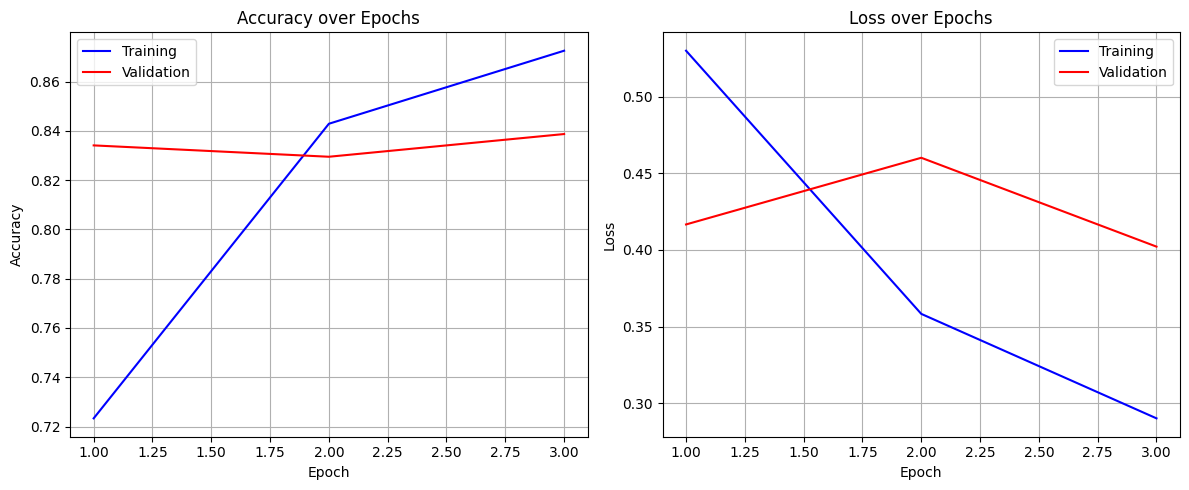

In [ ]:
# Membuat plot akurasi training dan validasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_accuracies, 'b-', label='Training')
plt.plot(range(1, num_epochs+1), val_accuracies, 'r-', label='Validation')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses, 'b-', label='Training')
plt.plot(range(1, num_epochs+1), val_losses, 'r-', label='Validation')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_validation_metrics.png')
plt.show()

In [ ]:
# Menyimpan model
output_dir = "./indobert_sentiment_model/"
os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model dan tokenizer disimpan di {output_dir}")